In [1]:
!pip install tensorflow

  Obtaining dependency information for tensorflow from https://files.pythonhosted.org/packages/ed/b6/62345568cd07de5d9254fcf64d7e44aacbb6abde11ea953b3cb320e58d19/tensorflow-2.17.0-cp311-cp311-win_amd64.whl.metadata
  Using cached tensorflow-2.17.0-cp311-cp311-win_amd64.whl.metadata (3.2 kB)
  Obtaining dependency information for tensorflow-intel==2.17.0 from https://files.pythonhosted.org/packages/66/03/5c447feceb72f5a38ac2aa79d306fa5b5772f982c2b480c1329c7e382900/tensorflow_intel-2.17.0-cp311-cp311-win_amd64.whl.metadata
  Using cached tensorflow_intel-2.17.0-cp311-cp311-win_amd64.whl.metadata (5.0 kB)
  Obtaining dependency information for absl-py>=1.0.0 from https://files.pythonhosted.org/packages/a2/ad/e0d3c824784ff121c03cc031f944bc7e139a8f1870ffd2845cc2dd76f6c4/absl_py-2.1.0-py3-none-any.whl.metadata
  Using cached absl_py-2.1.0-py3-none-any.whl.metadata (2.3 kB)
  Obtaining dependency information for astunparse>=1.6.0 from https://files.pythonhosted.org/packages/2b/03/13dde6512ad7

DEPRECATION: textract 1.6.5 has a non-standard dependency specifier extract-msg<=0.29.*. pip 23.3 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of textract or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063


In [2]:
#importing libraries
import pandas as pd
import json
import re
import string
import random
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense
import matplotlib.pyplot as plt
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras import layers
from tensorflow.keras.layers import Layer

In [3]:
def json_to_dataframe_from_file(file_path):
    # Read the JSON data from the file
    with open(file_path, 'r') as file:
        json_data = json.load(file)

    # Convert JSON data to a DataFrame
    records = []
    for item in json_data:
        context = item['context']
        for qa in item['qas']:
            question = qa['question']
            answer = qa['answer']
            records.append({
                'context': context,
                'question': question,
                'answer': answer
            })
    return pd.DataFrame(records)

In [4]:
# Example usage
file_path = 'traindata.json'  # Replace with your JSON file path
df = json_to_dataframe_from_file(file_path)
pd.set_option('display.max_columns', None)
df.head()

,context,question,answer
0,The financial information reported in this doc...,What financial reporting standards were used i...,International Financial Reporting Standards (I...
1,The financial information reported in this doc...,What period do the financial statements cover?,The quarter and six-month period ended April 3...
2,The financial information reported in this doc...,In what currency are the amounts presented?,All amounts are presented in Canadian dollars.
3,"For the second quarter of 2024, National Bank ...",What was the net income for the second quarter...,$906 million.
4,"For the second quarter of 2024, National Bank ...",How did the net income for the second quarter ...,Net income increased by 9% from $832 million i...


In [5]:
text_pairs = []
# Create text pairs with [start] and [end] tags for the answer
for index, row in df.iterrows():
    question = row['question']
    answer =  "[start] " + row['answer'] + " [end]"
    text_pairs.append((question, answer))

In [6]:
# Print a few random text pairs to verify
for _ in range(5):
    print(random.choice(text_pairs))

('What was the net income for Financial Markets in the second quarter of 2024?', '[start] The net income for Financial Markets in the second quarter of 2024 was $322 million. [end]')
('How did the net income for the Wealth Management segment change compared to the second quarter of 2023?', '[start] Net income increased by 15% from $178 million in the second quarter of 2023 to $205 million in 2024. [end]')
('What financial reporting standards are used in the quarterly report?', '[start] The report is prepared in accordance with International Financial Reporting Standards (IFRS) as issued by the International Accounting Standards Board (IASB). [end]')
('What was the net income for the Personal and Commercial segment in the second quarter of 2024?', '[start] The net income for the Personal and Commercial segment in the second quarter of 2024 was $311 million. [end]')
('What were the total revenues for the Financial Markets segment in the second quarter of 2024?', '[start] $766 million. [e

### Train Test Split

In [7]:
# Spltting training, validation and test randomly
random.shuffle(text_pairs)
num_val_samples = int(0.15 * len(text_pairs))
num_train_samples = len(text_pairs) - 2 * num_val_samples
train_pairs = text_pairs[:num_train_samples]
val_pairs = text_pairs[num_train_samples : num_train_samples + num_val_samples]
test_pairs = text_pairs[num_train_samples + num_val_samples :]

In [8]:
#print train_pairs, val_pairs, test_pairs
print(f"{len(text_pairs)} total pairs")
print(f"{len(train_pairs)} training pairs")
print(f"{len(val_pairs)} validation pairs")
print(f"{len(test_pairs)} test pairs")

39 total pairs
29 training pairs
5 validation pairs
5 test pairs


### Preprocessing

In [9]:
# preparing character for stripping
strip_chars = string.punctuation
strip_chars = strip_chars.replace("[", "")
strip_chars = strip_chars.replace("]", "")
#setting parameters
vocab_size = 2500
sequence_length = 100
batch_size = 64

In [10]:
# converting input to lower case
def custom_standardization(input_string):
    lowercase = tf.strings.lower(input_string)
    return tf.strings.regex_replace(lowercase, "[%s]" % re.escape(strip_chars), "")

In [11]:
# vectorizing queestion
question_vectorizer = TextVectorization(
    max_tokens=vocab_size,
    output_mode="int",
    output_sequence_length=sequence_length,
)

In [12]:
# vectorizing answers
answer_vectorizer = TextVectorization(
    max_tokens=vocab_size,
    output_mode="int",
    output_sequence_length=sequence_length + 1,
    standardize=custom_standardization
)

In [13]:
# Extracting text from training data
question_texts = [pair[0] for pair in train_pairs]
answer_texts = [pair[1] for pair in train_pairs]

In [14]:
# adapting the vectorization
question_vectorizer.adapt(question_texts)
answer_vectorizer.adapt(answer_texts)

In [15]:
print(len(question_vectorizer.get_vocabulary()))
question_vectorizer.get_vocabulary()

98


['',
 '[UNK]',
 'the',
 'what',
 'for',
 'of',
 '2024',
 'was',
 'income',
 'second',
 'quarter',
 'net',
 'in',
 'segment',
 'to',
 'how',
 'financial',
 'is',
 'did',
 'and',
 '2023',
 'personal',
 'period',
 'markets',
 'dividend',
 'commercial',
 'change',
 'april',
 '30',
 'management',
 'compared',
 'when',
 'were',
 'wealth',
 'total',
 'sixmonth',
 'share',
 'revenues',
 'ratio',
 'per',
 'half',
 'first',
 'ended',
 'earnings',
 'diluted',
 'declared',
 'cet1',
 'capital',
 'banks',
 'bank',
 'are',
 'who',
 'which',
 'used',
 'taxes',
 'taking',
 'statements',
 'standards',
 'significant',
 'segments',
 'saw',
 'same',
 'risk',
 'revenue',
 'reporting',
 'report',
 'receive',
 'quarterly',
 'provisions',
 'presented',
 'performance',
 'payable',
 'outlook',
 'on',
 'october',
 'may',
 'macroeconomic',
 'losses',
 'growth',
 'future',
 'from',
 'environment',
 'eligible',
 'do',
 'directors',
 'currency',
 'credit',
 'cover',
 'compare',
 'by',
 'board',
 'before',
 'as',
 'ap

In [16]:
#creating the constant for tensorflow
example_text = tf.constant("in what currency are the amounts presented")
#vectorizing the example text
example_text_tokens = question_vectorizer(example_text)
example_text_tokens

<tf.Tensor: shape=(100,), dtype=int64, numpy=
array([12,  3, 85, 50,  2, 94, 69,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
      dtype=int64)>

In [18]:
import numpy as np

In [19]:
# mapping token to the word
question_vocab = np.array(question_vectorizer.get_vocabulary())
tokens = question_vocab[example_text_tokens.numpy()] 
#tokens to string
' '.join(tokens)

'in what currency are the amounts presented                                                                                             '

In [20]:
example_text = tf.constant("[start] in what currency are the amounts presented [end]")
example_text_tokens = answer_vectorizer(example_text)
print(example_text_tokens)
answer_vocab = np.array(answer_vectorizer.get_vocabulary())
tokens = answer_vocab[example_text_tokens.numpy()]
print(' '.join(tokens))

tf.Tensor(
[ 2  6  1  1 94  4 96 59  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0], shape=(101,), dtype=int64)
[start] in [UNK] [UNK] are the amounts presented [end]                                                                                            


In [21]:
# formatting the text in dataset for seq2seq traingin   
def format_dataset(question, answers):
    questions = question_vectorizer(question)
    answers = answer_vectorizer(answers)
    return (
        {
            "encoder_inputs": questions,
            "decoder_inputs": answers[:, :-1],
        },
        answers[:, 1:],
    )

In [22]:
#function to create dataset
def make_dataset(pairs):
    questions, answers = zip(*pairs)
    questions = list(questions)
    answers = list(answers)
    dataset = tf.data.Dataset.from_tensor_slices((questions, answers))
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(format_dataset)
    return dataset.shuffle(2048).prefetch(16).cache()


In [23]:
#trainging and validation dataset
train_ds = make_dataset(train_pairs)
val_ds = make_dataset(val_pairs)

In [24]:
train_ds

<CacheDataset element_spec=({'encoder_inputs': TensorSpec(shape=(None, None), dtype=tf.int64, name=None), 'decoder_inputs': TensorSpec(shape=(None, None), dtype=tf.int64, name=None)}, TensorSpec(shape=(None, None), dtype=tf.int64, name=None))>

In [25]:
# Printing the encoded and decoded training 
for item in train_ds.take(1):
    print(f"Encoder input text: {question_vocab[item[0]['encoder_inputs'][0].numpy()]}")
    print(f"Decoder input text: {answer_vocab[item[0]['decoder_inputs'][0].numpy()]}")
    print(f"Decoder outputs: {answer_vocab[item[1][0].numpy()]}") 

Encoder input text: ['when' 'is' 'the' 'dividend' 'payable' '' '' '' '' '' '' '' '' '' '' ''
 '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' ''
 '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' ''
 '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' ''
 '' '' '' '' '' '' '' '' '' '' '' '']
Decoder input text: ['[start]' 'august' '1' '2024' '[end]' '' '' '' '' '' '' '' '' '' '' '' ''
 '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' ''
 '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' ''
 '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' ''
 '' '' '' '' '' '' '' '' '' '' '']
Decoder outputs: ['august' '1' '2024' '[end]' '' '' '' '' '' '' '' '' '' '' '' '' '' '' ''
 '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' ''
 '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' ''
 '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' 

In [26]:
#printing the shape of encoded and decoded inputs
for inputs, targets in train_ds.take(1):
    print(f'inputs["encoder_inputs"].shape: {inputs["encoder_inputs"].shape}')
    print(f'inputs["decoder_inputs"].shape: {inputs["decoder_inputs"].shape}')
    print(f"targets.shape: {targets.shape}")

inputs["encoder_inputs"].shape: (29, 100)
inputs["decoder_inputs"].shape: (29, 100)
targets.shape: (29, 100)


In [27]:
# manually defining encoder component of a Transformer model
class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.dense_proj = keras.Sequential(
            [
                layers.Dense(dense_dim, activation="relu"),
                layers.Dense(embed_dim),
            ]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.supports_masking = True

    def call(self, inputs, mask=None):
        attention_output = self.attention(query=inputs, value=inputs, key=inputs)
        proj_input = self.layernorm_1(inputs + attention_output)
        proj_output = self.dense_proj(proj_input)
        return self.layernorm_2(proj_input + proj_output)

In [28]:

class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, vocab_size, embed_dim, **kwargs):
        super().__init__(**kwargs)
        self.token_embeddings = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.position_embeddings = layers.Embedding(input_dim=sequence_length, output_dim=embed_dim)
        self.sequence_length = sequence_length
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim

    def call(self, inputs):
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1)
        # print(positions)
        embedded_tokens = self.token_embeddings(inputs)
        # print(f"tokens_embeddings: {embedded_tokens.shape}")
        embedded_positions = self.position_embeddings(positions)
        # print(f"position_embeddings: {embedded_positions.shape}")
        return embedded_tokens + embedded_positions
    
    def compute_mask(self, inputs, mask=None):
        return tf.math.not_equal(inputs, 0)


In [29]:
#decoder layer for a Transformer model
class TransformerDecoder(layers.Layer):
    def __init__(self, embed_dim, latent_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.latent_dim = latent_dim
        self.num_heads = num_heads
        self.attention_1 = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.attention_2 = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.dense_proj = keras.Sequential(
            [
                layers.Dense(latent_dim, activation="relu"),
                layers.Dense(embed_dim),
            ]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.layernorm_3 = layers.LayerNormalization()
        self.add = layers.Add()  # instead of `+` to preserve mask
        self.supports_masking = True

    def call(self, inputs, encoder_outputs, mask=None):
        attention_output_1 = self.attention_1(
            query=inputs, value=inputs, key=inputs, use_causal_mask=True
        )
        out_1 = self.layernorm_1(self.add([inputs, attention_output_1]))

        attention_output_2 = self.attention_2(
            query=out_1,
            value=encoder_outputs,
            key=encoder_outputs,
        )
        out_2 = self.layernorm_2(self.add([out_1, attention_output_2]))

        proj_output = self.dense_proj(out_2)
        return self.layernorm_3(self.add([out_2, proj_output]))

In [30]:
class CustomMaskingLayer(Layer):
    def call(self, inputs):
        return tf.math.not_equal(inputs, 0)

In [31]:
class PositionalEmbedding(Layer):
    def __init__(self, sequence_length, vocab_size, embed_dim, **kwargs):
        super(PositionalEmbedding, self).__init__(**kwargs)
        self.token_embeddings = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.position_embeddings = layers.Embedding(input_dim=sequence_length, output_dim=embed_dim)
        self.custom_masking = CustomMaskingLayer()

    def call(self, inputs):
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions

    def compute_mask(self, inputs, mask=None):
        return self.custom_masking(inputs)

In [32]:
embed_dim = 256
latent_dim = 2048
num_heads = 8

In [33]:
encoder_inputs = keras.Input(shape=(None,), dtype="int64", name="encoder_inputs")
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(encoder_inputs)
encoder_outputs = TransformerEncoder(embed_dim, latent_dim, num_heads)(x)
encoder = keras.Model(encoder_inputs, encoder_outputs)
decoder_inputs = keras.Input(shape=(None,), dtype="int64", name="decoder_inputs")
encoded_seq_inputs = keras.Input(shape=(None, embed_dim), name="decoder_state_inputs")

C:\Users\Saugat\anaconda3\Lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'positional_embedding', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


In [34]:
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(decoder_inputs)
x = TransformerDecoder(embed_dim, latent_dim, num_heads)(x, encoded_seq_inputs)
x = layers.Dropout(0.5)(x)
decoder_outputs = layers.Dense(vocab_size, activation="softmax")(x)
decoder = keras.Model([decoder_inputs, encoded_seq_inputs], decoder_outputs)
decoder_outputs = decoder([decoder_inputs, encoder_outputs])

C:\Users\Saugat\anaconda3\Lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'positional_embedding_1', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
C:\Users\Saugat\anaconda3\Lib\site-packages\keras\src\layers\layer.py:934: UserWarning: Layer 'functional_3' (of type Functional) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


In [35]:
# defining tranformer model
transformer = keras.Model(
    [encoder_inputs, decoder_inputs], decoder_outputs, name="transformer"
)

In [36]:
# compiling model
transformer.compile(
    "rmsprop", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
)

In [37]:
# Fitting the model
history=transformer.fit(train_ds, epochs=50, validation_data=val_ds)

Epoch 1/50


C:\Users\Saugat\anaconda3\Lib\site-packages\keras\src\layers\layer.py:934: UserWarning: Layer 'query' (of type EinsumDense) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
C:\Users\Saugat\anaconda3\Lib\site-packages\keras\src\layers\layer.py:934: UserWarning: Layer 'key' (of type EinsumDense) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
C:\Users\Saugat\anaconda3\Lib\site-packages\keras\src\layers\layer.py:934: UserWarning: Layer 'value' (of type EinsumDense) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
C:\Users\Saugat\anaconda3\Lib\

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step - accuracy: 0.0000e+00 - loss: 8.0645 - val_accuracy: 0.9000 - val_loss: 6.1015
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.9024 - loss: 5.6589 - val_accuracy: 0.9020 - val_loss: 5.7498
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.8083 - loss: 5.0221 - val_accuracy: 0.9000 - val_loss: 5.7107
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.9024 - loss: 5.0645 - val_accuracy: 0.9020 - val_loss: 5.0158
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.9066 - loss: 4.2973 - val_accuracy: 0.8120 - val_loss: 4.9048
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.5741 - loss: 3.9626 - val_accuracy: 0.9000 - val_loss: 4.9156
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.9028 - loss: 3.9144 - val_accuracy: 0.9040 - val_loss: 4.5592
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.9086 - loss: 3.6216 - val_accuracy: 0.9020 - val_loss: 4.4892
Epoch 9/50
1/1 ━━━━━━━━

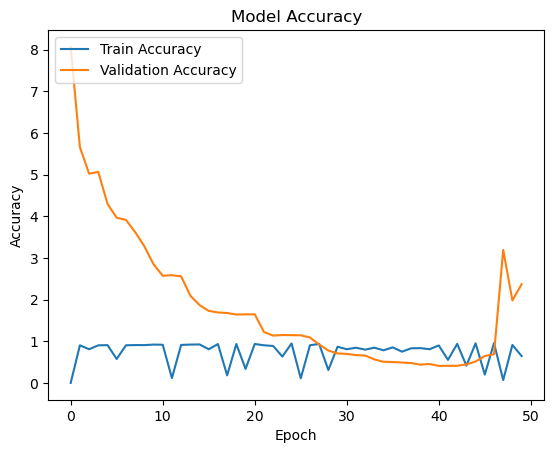

In [38]:
# Plot model accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['loss'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')
plt.show()

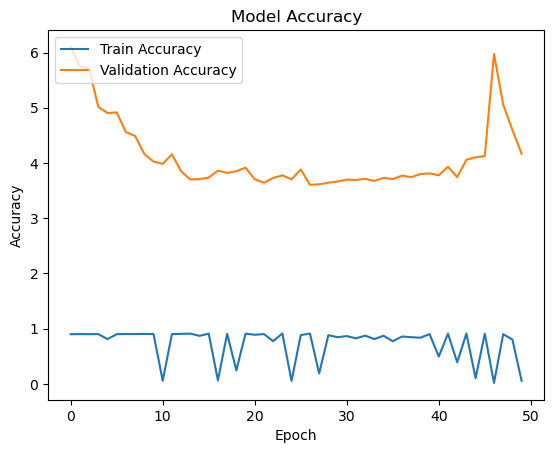

In [39]:
# Plot model accuracy
plt.plot(history.history['val_accuracy'], label='Train Accuracy')
plt.plot(history.history['val_loss'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')
plt.show()

In [40]:
# Function to generate response and prediction
answer_index_lookup = dict(zip(range(len(answer_vocab)), answer_vocab))
max_decoded_sentence_length = 100
def decode_sequence(input_sentence):
    tokenized_input_sentence = question_vectorizer([input_sentence])
    decoded_sentence = "[start]"
    for i in range(max_decoded_sentence_length):
        tokenized_target_sentence = answer_vectorizer([decoded_sentence])[:, :-1]
        predictions = transformer([tokenized_input_sentence, tokenized_target_sentence])
        sampled_token_index = np.argmax(predictions[0, i, :])
        sampled_token = answer_index_lookup[sampled_token_index]
        decoded_sentence += " " + sampled_token
        if sampled_token == "[end]":
            break
    return decoded_sentence

In [41]:
test_eng_texts = [pair[0] for pair in train_pairs]
#checking the question and answer for the bot
question =  'what was the net income for the second quarter of 2024'
print(f"Q: {question}")
answer = decode_sequence(question)
print(f"Chatty: {answer}")

Q: what was the net income for the second quarter of 2024
Chatty: [start] the the the the the the the the in the the the the the the the the in the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the
